#SUPERSTORE SALES DATASET ANALYSIS USING APACHE SPARK

## 1. Project Overview
This project explores sales, customer behavior, and logistics performance
using Apache Spark DataFrames.

##2. Data Preparation

### 2.1 Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
from pyspark.sql.types import DoubleType

spark = SparkSession.builder.appName("University_Project").getOrCreate()

path = "/content/drive/MyDrive/Sparks/train.csv"

###2.2 Data Frame Definition

In [ ]:
# ---------------------------------------------------------
# DF1: MASTER VIEW
# ---------------------------------------------------------

df1 = spark.read.csv(path, header=True, inferSchema=True, quote='"', escape='"', multiLine=True) \
    .withColumn("Order Date", to_date(col("Order Date"), "dd/MM/yyyy")) \
    .withColumn("Ship Date", to_date(col("Ship Date"), "dd/MM/yyyy")) \
    .cache()

# Display the "Base Table"
print("--- DF1: Master Table ---")
df1.show(5)

--- DF1: Master Table ---
+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+
|Row ID|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|  Customer Name|  Segment|      Country|           City|     State|Postal Code|Region|     Product ID|       Category|Sub-Category|        Product Name|   Sales|
+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+
|     1|CA-2017-152156|2017-11-08|2017-11-11|  Second Class|   CG-12520|    Claire Gute| Consumer|United States|      Henderson|  Kentucky|      42420| South|FUR-BO-10001798|      Furniture|   Bookcases|Bush Somerset Col...|  261.96|
|     2|CA-2017-152156|2017-11-08|2017

In [ ]:
from pyspark.sql.functions import date_format, add_months, sum as _sum, round, col, to_date, avg, when

# ---------------------------------------------------------
# DF2: MONTHLY GROWTH & MOMENTUM ENGINE
# ---------------------------------------------------------

# 1. Calculate Monthly Sales (Aggregating daily sales first)
monthly_sales = df1.groupBy(col("Order Date"), "Segment") \
    .agg(_sum("Sales").alias("Daily_Sales")) \
    .withColumn("Month_Start", to_date(date_format(col("Order Date"), "yyyy-MM-01"))) \
    .groupBy("Month_Start", "Segment") \
    .agg(_sum("Daily_Sales").alias("Current_Sales"))

# 2. Create "Previous Month" View (Shift date by 1 month)
prev_month_view = monthly_sales.select(
    add_months(col("Month_Start"), 1).alias("Join_Date"),
    col("Segment").alias("Join_Segment"),
    col("Current_Sales").alias("Prev_Sales")
)

# 3. Join & Calculate Growth
df2 = monthly_sales.join(
    prev_month_view,
    (monthly_sales.Month_Start == prev_month_view.Join_Date) &
    (monthly_sales.Segment == prev_month_view.Join_Segment),
    how="left"
).select(
    col("Month_Start"),
    col("Segment"),
    round(col("Current_Sales"), 2).alias("Current_Sales"),
    round(col("Prev_Sales"), 2).alias("Prev_Sales"),
    round(((col("Current_Sales") - col("Prev_Sales")) / col("Prev_Sales")) * 100, 2).alias("Growth_Pct")
).cache()

# Display the Engine
print("--- DF2: Monthly Growth Table ---")
df2.show(5)

--- DF2: Monthly Growth Table ---
+-----------+-----------+-------------+----------+----------+
|Month_Start|    Segment|Current_Sales|Prev_Sales|Growth_Pct|
+-----------+-----------+-------------+----------+----------+
| 2015-06-01|  Corporate|      3970.91|    9142.0|    -56.56|
| 2016-01-01|Home Office|       516.63|  11614.08|    -95.55|
| 2017-02-01|Home Office|       4311.7|   3030.72|     42.27|
| 2017-05-01|   Consumer|     32174.64|  14004.98|    129.74|
| 2017-01-01|Home Office|      3030.72|  19051.73|    -84.09|
+-----------+-----------+-------------+----------+----------+
only showing top 5 rows


In [ ]:
from pyspark.sql.functions import dayofweek, when

# ---------------------------------------------------------
# DF3: DAILY SALES VIEW
# ---------------------------------------------------------

# 1. Helper Logic: Create the "Calendar View"
# Note: dayofweek(1) = Sunday, dayofweek(7) = Saturday
df_calendar = df1.select("Order Date").distinct() \
    .withColumn("DayNum", dayofweek(col("Order Date"))) \
    .withColumn("DayType", when(col("DayNum").isin(1, 7), "Weekend").otherwise("Weekday"))

# 2. Perform the Join
df3 = df1.join(df_calendar, on="Order Date", how="inner") \
    .select(
        col("Order Date"),
        round(col("Sales"), 2).alias("Sales"),
        col("DayType")
    )

# Display
print("--- DF3: Daily Sales Table ---")
df3.show()

--- DF3: Daily Sales Table ---
+----------+------+-------+
|Order Date| Sales|DayType|
+----------+------+-------+
|2018-05-28|115.96|Weekday|
|2018-05-28| 13.87|Weekday|
|2018-05-28|125.13|Weekday|
|2018-05-28| 27.46|Weekday|
|2018-05-28|271.97|Weekday|
|2018-05-28| 15.55|Weekday|
|2018-05-28|195.96|Weekday|
|2018-05-28|  3.56|Weekday|
|2018-05-28|106.87|Weekday|
|2018-05-28|247.44|Weekday|
|2018-05-28| 54.37|Weekday|
|2018-05-28|301.96|Weekday|
|2017-09-11|  9.57|Weekday|
|2017-09-11| 20.74|Weekday|
|2017-09-11|  2.91|Weekday|
|2017-09-11|  1.91|Weekday|
|2017-09-11|   6.0|Weekday|
|2017-09-11|224.75|Weekday|
|2017-09-11| 39.87|Weekday|
|2017-09-11|332.94|Weekday|
+----------+------+-------+
only showing top 20 rows


In [ ]:
from pyspark.sql.functions import datediff, udf, col, when
from pyspark.sql.types import StringType

# ---------------------------------------------------------
# DF4: SHIPPING PERFORMANCE STATUS VIEW
# ---------------------------------------------------------

# 1. UDF Definition
def delivery_speed(days):
    if days is None: return "Unknown"
    return "Priority" if days <= 2 else "Standard"

speed_udf = udf(delivery_speed, StringType())

# 2. Transformation
df4 = df1.withColumn("Shipping_Delay", datediff(col("Ship Date"), col("Order Date"))) \
    .withColumn("Service_Level", speed_udf(col("Shipping_Delay"))) \
    .withColumn("Max_Days_Allowed",
                when(col("Ship Mode") == "Standard Class", 6)
                .when(col("Ship Mode") == "Second Class", 4)
                .when(col("Ship Mode") == "First Class", 2)
                .when(col("Ship Mode") == "Same Day", 0)
                .otherwise(5)) \
    .withColumn("Delivery_Status",
                when(col("Shipping_Delay") <= col("Max_Days_Allowed"), "On Time")
                .otherwise("Late Delivery")) \
    .select("City", "Order Date", "Service_Level", "Shipping_Delay", "Delivery_Status")

# Display
print("--- DF4: Shipping Performance Table ---")
df4.show(5)

--- DF4: Shipping Performance Table ---
+---------------+----------+-------------+--------------+---------------+
|           City|Order Date|Service_Level|Shipping_Delay|Delivery_Status|
+---------------+----------+-------------+--------------+---------------+
|      Henderson|2017-11-08|     Standard|             3|        On Time|
|      Henderson|2017-11-08|     Standard|             3|        On Time|
|    Los Angeles|2017-06-12|     Standard|             4|        On Time|
|Fort Lauderdale|2016-10-11|     Standard|             7|  Late Delivery|
|Fort Lauderdale|2016-10-11|     Standard|             7|  Late Delivery|
+---------------+----------+-------------+--------------+---------------+
only showing top 5 rows


Assumptions:

1. Delivery Speed Classification

Since all shipments are domestic (US → US), we define "Priority" delivery as completion within 0–2 days, reflecting common premium shipping standards (same-day, next-day, and two-day delivery) in US e-commerce. Deliveries taking 3+ days are labeled as "Standard".

2. Maximum Days Allowed per Ship Mode

Expected delivery time thresholds are assigned based on the selected ship mode to approximate typical service-level agreements (SLAs). Specifically, Same Day allows 0 days, First Class 2 days, Second Class 4 days, and Standard Class 6 days. Orders exceeding these thresholds are classified as Late Delivery.



In [ ]:
from pyspark.sql.functions import (
    sum as _sum, count, countDistinct, avg,
    max as _max, when, col, round, desc
)

# ---------------------------------------------------------
# DF5: CUSTOMER VALUE & LOYALTY SEGMENTATION VIEW
# ---------------------------------------------------------

# 1. Customer Feature Definition
df_customer_stats = df1.groupBy("Customer ID", "Customer Name", "City", "Segment") \
    .agg(
        count("Order ID").alias("Frequency"),
        round(_sum("Sales"), 2).alias("Lifetime_Value"),
        round(avg("Sales"), 2).alias("Avg_Ticket_Size"),
        countDistinct("Category").alias("Category_Diversity")
    )

# 2. Loyalty Tier Assignment
df5 = df_customer_stats.withColumn(
    "Loyalty_Tier",
    when((col("Lifetime_Value") > 3000) | (col("Category_Diversity") == 3), "Gold")
    .when(col("Lifetime_Value") > 1000, "Silver")
    .otherwise("Bronze")
)

# Display the complex view
print("--- DF5: Customer Sgementation Table ---")
df5.orderBy(desc("Lifetime_Value")).show(5)


--- DF5: Customer Sgementation Table ---
+-----------+-------------+-------------+-----------+---------+--------------+---------------+------------------+------------+
|Customer ID|Customer Name|         City|    Segment|Frequency|Lifetime_Value|Avg_Ticket_Size|Category_Diversity|Loyalty_Tier|
+-----------+-------------+-------------+-----------+---------+--------------+---------------+------------------+------------+
|   SM-20320|  Sean Miller| Jacksonville|Home Office|        7|      23661.23|        3380.18|                 3|        Gold|
|   TC-20980| Tamara Chand|    Lafayette|  Corporate|        5|      18336.74|        3667.35|                 2|        Gold|
|   RB-19360| Raymond Buch|      Seattle|   Consumer|        3|      14052.48|        4684.16|                 2|        Gold|
|   TA-21385| Tom Ashbrook|New York City|Home Office|        5|       13723.5|         2744.7|                 2|        Gold|
|   BM-11140| Becky Martin|  San Antonio|   Consumer|        7|       

Assumption:

1. Customer Loyalty Tier Definition

Customers are grouped into loyalty tiers using fixed spending thresholds to separate high-value customers from the rest. A lifetime value threshold of 3000 is used to identify high-spending (Gold) customers, while category diversity is included to reflect how broadly customers engage with different product categories. This segmentation is used to support customer profiling and cross-selling analysis.

In [ ]:
from pyspark.sql.functions import sum as _sum, avg, round, desc

# ---------------------------------------------------------
# DF6: CATEGORY REVENUE & PRICING PROFILE VIEW
# ---------------------------------------------------------

# 1. Simple Aggregation: Total Money vs Average Price per Item
df6 = df1.groupBy("Category").agg(
    round(_sum("Sales"), 2).alias("Total_Revenue"),
    round(avg("Sales"), 2).alias("Avg_Ticket_Size")
)

# Display
print("--- DF6: Category Revenue vs Price ---")
df6.orderBy(desc("Total_Revenue")).show()

--- DF6: Category Revenue vs Price ---
+---------------+-------------+---------------+
|       Category|Total_Revenue|Avg_Ticket_Size|
+---------------+-------------+---------------+
|     Technology|    827455.87|          456.4|
|      Furniture|    728658.58|         350.65|
|Office Supplies|    705422.33|         119.38|
+---------------+-------------+---------------+



##3. Queries

###3.1 Identify the dominant product category in each city

In [ ]:
from pyspark.sql.functions import sum as _sum, max, col, round

# 1. Group by total sales, per category and city
df_base = df1.groupBy("City", "Category").agg(round(_sum("Sales"), 2).alias("Total"))

# 2. Join with max value then filter and drill down
q1 = df_base.join(
    df_base.groupBy("City").agg(max("Total").alias("Max_Val")),
    on="City"
).filter(col("Total") == col("Max_Val")) \
 .select("City", "Category", "Total") \
 .orderBy(col("Total").desc())

# Show result
print("--- Q1: Top Category per City ---")
q1.show(5)

--- Q1: Top Category per City ---
+-------------+---------------+---------+
|         City|       Category|    Total|
+-------------+---------------+---------+
|New York City|     Technology|108980.14|
|  Los Angeles|     Technology| 72249.71|
|      Seattle|     Technology| 42506.37|
|San Francisco|Office Supplies| 41918.45|
| Philadelphia|     Technology| 41772.12|
+-------------+---------------+---------+
only showing top 5 rows


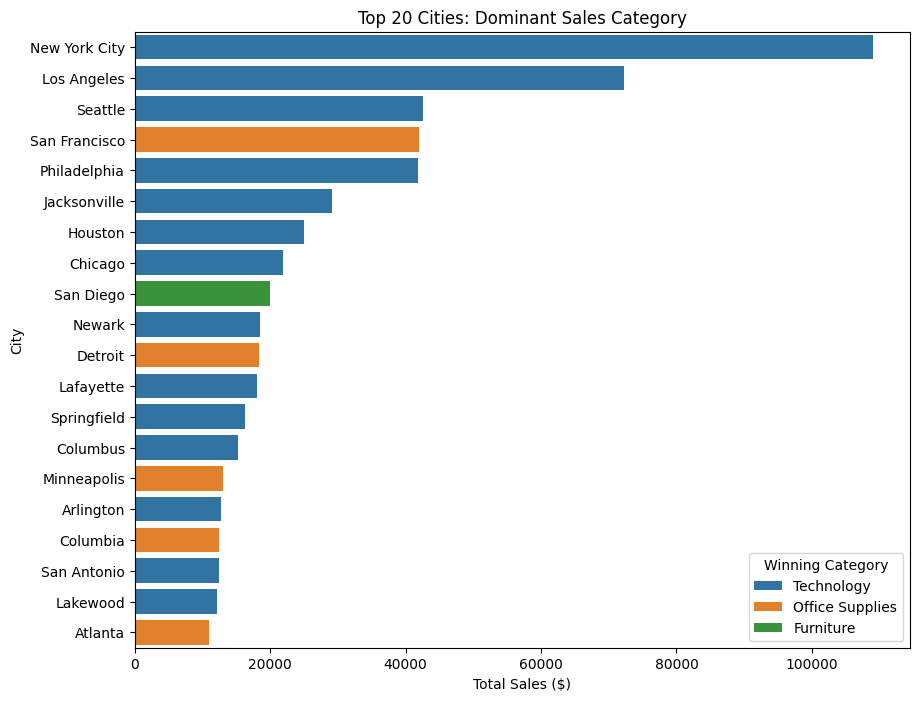

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convert to Pandas
pdf1 = q1.toPandas()

# --- THE FIX ---
# Take only the top 20 cities by sales to clear the mess
pdf1_top20 = pdf1.head(20)

plt.figure(figsize=(10, 8))
chart = sns.barplot(
    data=pdf1_top20,
    x="Total",
    y="City",
    hue="Category",
    dodge=False
)

plt.title("Top 20 Cities: Dominant Sales Category")
plt.xlabel("Total Sales ($)")
plt.ylabel("City")
plt.legend(title="Winning Category", loc="lower right")
plt.show()

###3.2 Identify the top three sub-categories within the category with the highest total sales

In [ ]:
from pyspark.sql.functions import sum as _sum, col, desc, round

# 1. Find the #1 Category (Keep it as a DataFrame)
top_cat_df = df1.groupBy("Category").agg(_sum("Sales").alias("Cat_Sales")) \
    .orderBy(desc("Cat_Sales")) \
    .limit(1)

# 2. Join to Filter & Drill Down (Pure Relational Logic)
q2 = df1.join(top_cat_df, on="Category", how="inner") \
    .groupBy("Sub-Category").agg(round(_sum("Sales"), 2).alias("Revenue")) \
    .orderBy(desc("Revenue")) \
    .limit(3)

# Show result
print("--- Q2: Top 3 Sub-Categories ---")
q2.show()

--- Q2: Top 3 Sub-Categories ---
+------------+---------+
|Sub-Category|  Revenue|
+------------+---------+
|      Phones|327782.45|
|    Machines|189238.63|
| Accessories| 164186.7|
+------------+---------+



/tmp/ipython-input-640450952.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


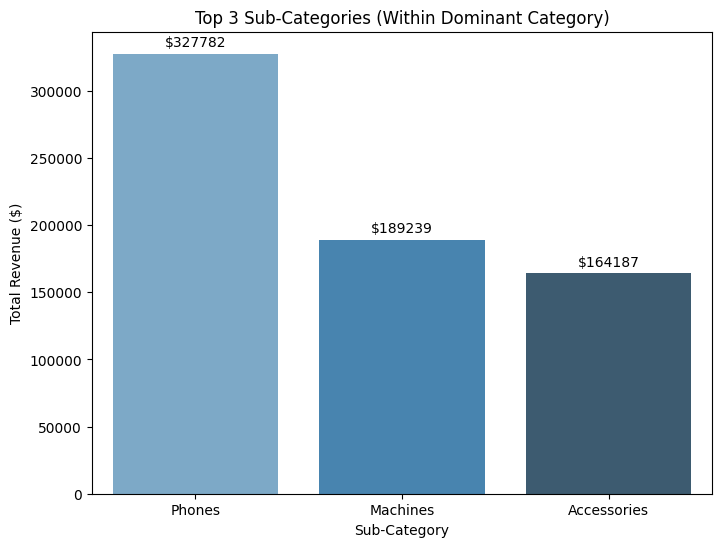

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convert Spark DataFrame to Pandas
pdf2 = q2.toPandas()

# 2. Create the Visual
plt.figure(figsize=(8, 6))

# We use a sequential palette ('Blues_d') to emphasize the ranking order
ax = sns.barplot(
    data=pdf2,
    x="Sub-Category",
    y="Revenue",
    palette="Blues_d"
)

# 3. Add Labels and Titles
plt.title("Top 3 Sub-Categories (Within Dominant Category)")
plt.ylabel("Total Revenue ($)")
plt.xlabel("Sub-Category")

# Optional: Add the exact dollar values on top of the bars
for i in ax.containers:
    ax.bar_label(i, fmt='$%.0f', padding=3)

plt.show()

###3.3 Compute the average monthly revenue for Consumer customers

In [ ]:
# 1. Filter rows
q3 = df2.filter(col("Segment") == "Consumer") \
    .agg(round(avg("Current_Sales"), 2).alias("Avg_Monthly_Revenue"))

# Show result
print("--- Q3: Average Monthly Revenue ---")
q3.show()

--- Q3: Average Monthly Revenue ---
+-------------------+
|Avg_Monthly_Revenue|
+-------------------+
|           23917.93|
+-------------------+



### 3.4 Analyze the time evolution of sales, grouped by Corporate and Consumer segments

In [ ]:
from pyspark.sql.functions import sum, when, col, round

# This allows us to instantly compare Consumer vs Corporate performance for every month.

q4 = df2.groupBy("Month_Start") \
    .agg(
        round(
            sum(when(col("Segment") == "Consumer", col("Current_Sales"))),2).alias("Consumer_Sales"),
        round(
            sum(when(col("Segment") == "Corporate", col("Current_Sales"))),2).alias("Corporate_Sales")
    ) \
    .orderBy("Month_Start")

print("--- Q4: Consumer and Corporate Sales Growth ---")
q4.show(40)

--- Q4: Consumer and Corporate Sales Growth ---
+-----------+--------------+---------------+
|Month_Start|Consumer_Sales|Corporate_Sales|
+-----------+--------------+---------------+
| 2015-01-01|       6896.63|        1701.53|
| 2015-02-01|       3167.85|        1183.67|
| 2015-03-01|       11869.3|       10952.18|
| 2015-04-01|       9108.61|       13743.24|
| 2015-05-01|      12815.18|         9142.0|
| 2015-06-01|      25651.56|        3970.91|
| 2015-07-01|      20032.89|       10032.99|
| 2015-08-01|      15423.33|        7451.77|
| 2015-09-01|      59536.83|       15507.75|
| 2015-10-01|       16246.7|       12637.68|
| 2015-11-01|       46228.5|       20900.23|
| 2015-12-01|      35979.42|       20573.56|
| 2016-01-01|      14274.98|        3275.35|
| 2016-02-01|       9269.02|        2565.26|
| 2016-03-01|      17418.89|       10394.13|
| 2016-04-01|      22626.41|        4121.04|
| 2016-05-01|      20792.08|        5454.94|
| 2016-06-01|       12824.5|        8466.48|
| 2016-

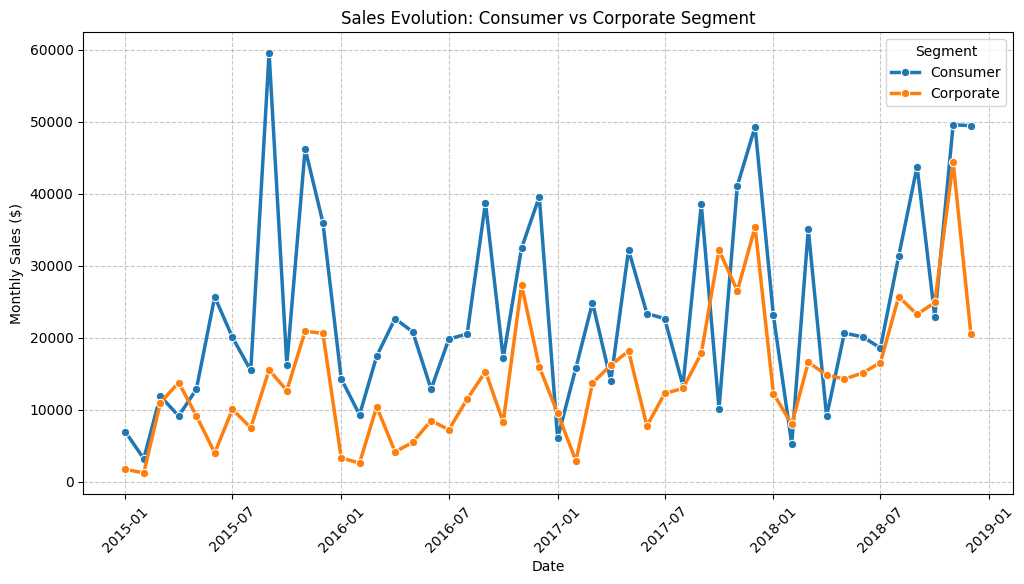

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Convert Spark DataFrame to Pandas
pdf4 = q4.toPandas()

# 2. Ensure the date column is in the correct format for plotting
pdf4['Month_Start'] = pd.to_datetime(pdf4['Month_Start'])

# 3. Create the Visual
plt.figure(figsize=(12, 6))

# Plot the Consumer line
sns.lineplot(
    data=pdf4,
    x='Month_Start',
    y='Consumer_Sales',
    label='Consumer',
    marker='o',       # Adds dots to data points
    linewidth=2.5     # Makes line thicker
)

# Plot the Corporate line
sns.lineplot(
    data=pdf4,
    x='Month_Start',
    y='Corporate_Sales',
    label='Corporate',
    marker='o',
    linewidth=2.5
)

# 4. Formatting
plt.title("Sales Evolution: Consumer vs Corporate Segment")
plt.ylabel("Monthly Sales ($)")
plt.xlabel("Date")
plt.legend(title="Segment")
plt.grid(True, linestyle='--', alpha=0.7) # Adds a subtle grid for readability

# Rotate dates slightly to prevent overlapping
plt.xticks(rotation=45)

plt.show()

### 3.5 Compare average daily sales efficiency between weekdays and weekends

In [ ]:
from pyspark.sql.functions import sum as _sum, avg, count, round

#1. Group By Day Type, Count Days Active, and Average Sales per Day Type
q5 = df3.groupBy("Order Date", "DayType").agg(_sum("Sales").alias("Daily_Total")) \
    .groupBy("DayType").agg(
        count("Order Date").alias("Days_Active"),
        round(avg("Daily_Total"), 2).alias("Avg_Daily_Sales")
    )

# Show result
print("--- Q5: Daily Sales Efficiency ---")
q5.show()

--- Q5: Daily Sales Efficiency ---
+-------+-----------+---------------+
|DayType|Days_Active|Avg_Daily_Sales|
+-------+-----------+---------------+
|Weekday|        831|        1760.25|
|Weekend|        399|        2001.93|
+-------+-----------+---------------+



/tmp/ipython-input-542983476.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


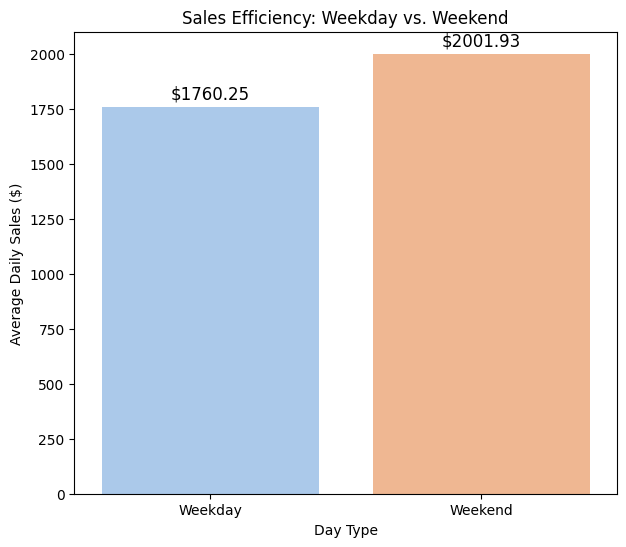

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convert Spark DataFrame to Pandas
pdf5 = q5.toPandas()

# 2. Create the Visual
plt.figure(figsize=(7, 6))

# Plot the bars
ax = sns.barplot(
    data=pdf5,
    x="DayType",
    y="Avg_Daily_Sales",
    palette="pastel"
)

# 3. Add Labels and Titles
plt.title("Sales Efficiency: Weekday vs. Weekend")
plt.ylabel("Average Daily Sales ($)")
plt.xlabel("Day Type")

# 4. Add value labels on top of the bars for instant reading
for i in ax.containers:
    ax.bar_label(i, fmt='$%.2f', padding=3, fontsize=12)

plt.show()

### 3.6 Failure Rate. Identify the percentage of orders in a city failed to meet the promised shipping speed

In [ ]:
from pyspark.sql.functions import avg, count, when, col, round, desc

# Insight: "Reliability Audit". We calculate the percentage of orders
# that failed to meet their promised delivery date (Late Delivery).

q6 = df4.groupBy("City") \
    .agg(
        count("City").alias("Total_Orders"),
        round(avg("Shipping_Delay"), 1).alias("Avg_Days"),
        round(avg(when(col("Delivery_Status") == "Late Delivery", 1).otherwise(0)) * 100, 1).alias("Failure_Rate_Pct")
    ) \
    .filter(col("Total_Orders") > 10) \
    .orderBy(desc("Failure_Rate_Pct")) \
    .limit(5)

# Show result
print("--- Q6: Failure Rate in Percentage ---")
q6.show()

--- Q6: Failure Rate in Percentage ---
+--------------+------------+--------+----------------+
|          City|Total_Orders|Avg_Days|Failure_Rate_Pct|
+--------------+------------+--------+----------------+
|     Lakeville|          15|     6.0|            93.3|
|        Quincy|          20|     4.2|            60.0|
|Pembroke Pines|          14|     6.0|            57.1|
|     Brentwood|          16|     5.1|            56.3|
|       Chester|          16|     3.6|            56.3|
+--------------+------------+--------+----------------+



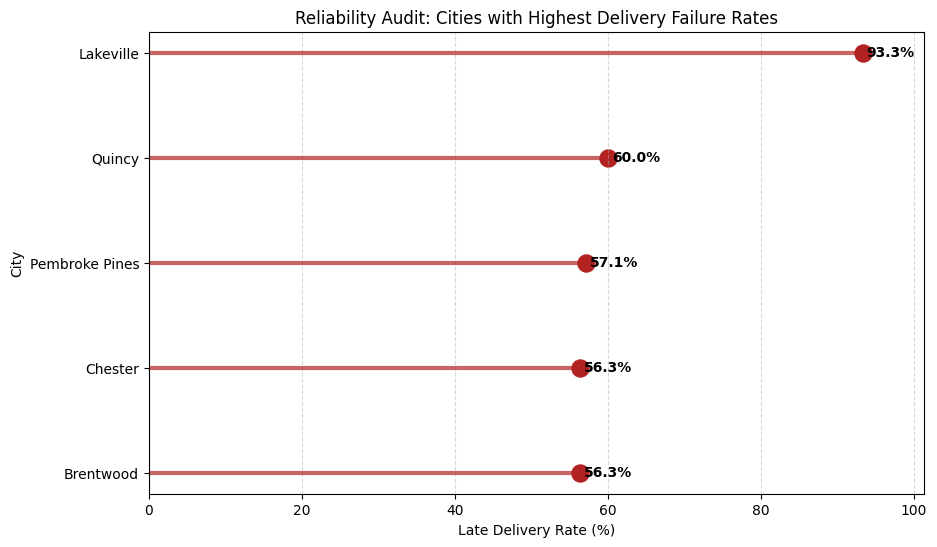

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convert Spark DataFrame to Pandas
pdf6 = q6.toPandas()

# Sort so the worst city (highest failure) appears at the top
pdf6 = pdf6.sort_values("Failure_Rate_Pct", ascending=True)

# 2. Create the Visual (Lollipop Chart)
plt.figure(figsize=(10, 6))

# Draw the lines (stems)
plt.hlines(
    y=pdf6['City'],
    xmin=0,
    xmax=pdf6['Failure_Rate_Pct'],
    color='firebrick',
    alpha=0.7,
    linewidth=3
)

# Draw the dots (heads)
plt.scatter(
    pdf6['Failure_Rate_Pct'],
    pdf6['City'],
    color='firebrick',
    s=150,
    alpha=1
)

# 3. Add exact percentage labels next to the dots
for i, row in enumerate(pdf6.itertuples()):
    plt.text(
        x=row.Failure_Rate_Pct + 0.5,
        y=i,
        s=f"{row.Failure_Rate_Pct}%",
        va='center',
        color='black',
        fontweight='bold'
    )

# 4. Styling
plt.title("Reliability Audit: Cities with Highest Delivery Failure Rates")
plt.xlabel("Late Delivery Rate (%)")
plt.ylabel("City")
plt.xlim(0, pdf6['Failure_Rate_Pct'].max() + 8) # Add breathing room for text labels
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

### 3.7 For each category, determine the most sold product in the month of December

In [ ]:
from pyspark.sql.functions import month, count, max as _max, col

# Insight: Identify the single most popular product for each category in December.

# 1. Base Stats: Count December Sales per Product
dec_stats = df1.filter(month("Order Date") == 12) \
    .groupBy("Category", "Product Name") \
    .agg(count("Product Name").alias("Units"))

# 2. Logic: Join the stats with the Max value per Category to keep only winners
q7 = dec_stats.join(
    dec_stats.groupBy("Category").agg(_max("Units").alias("Max_Units")),
    on="Category"
).filter(col("Units") == col("Max_Units")) \
 .select("Category", "Product Name", "Units") \
 .orderBy(col("Units").desc())

print("--- Q7: Top Products per Category in December ---")
q7.show(50)

--- Q7: Top Products per Category in December ---
+---------------+--------------------+-----+
|       Category|        Product Name|Units|
+---------------+--------------------+-----+
|Office Supplies|     Staple envelope|    6|
|Office Supplies|           Xerox 214|    6|
|      Furniture|3M Hangers With C...|    5|
|      Furniture|DMI Arturo Collec...|    5|
|      Furniture|Bretford Rectangu...|    5|
|     Technology|Plantronics Savi ...|    4|
|     Technology|AT&T 1080 Corded ...|    4|
|     Technology|         GE 30524EE4|    4|
+---------------+--------------------+-----+



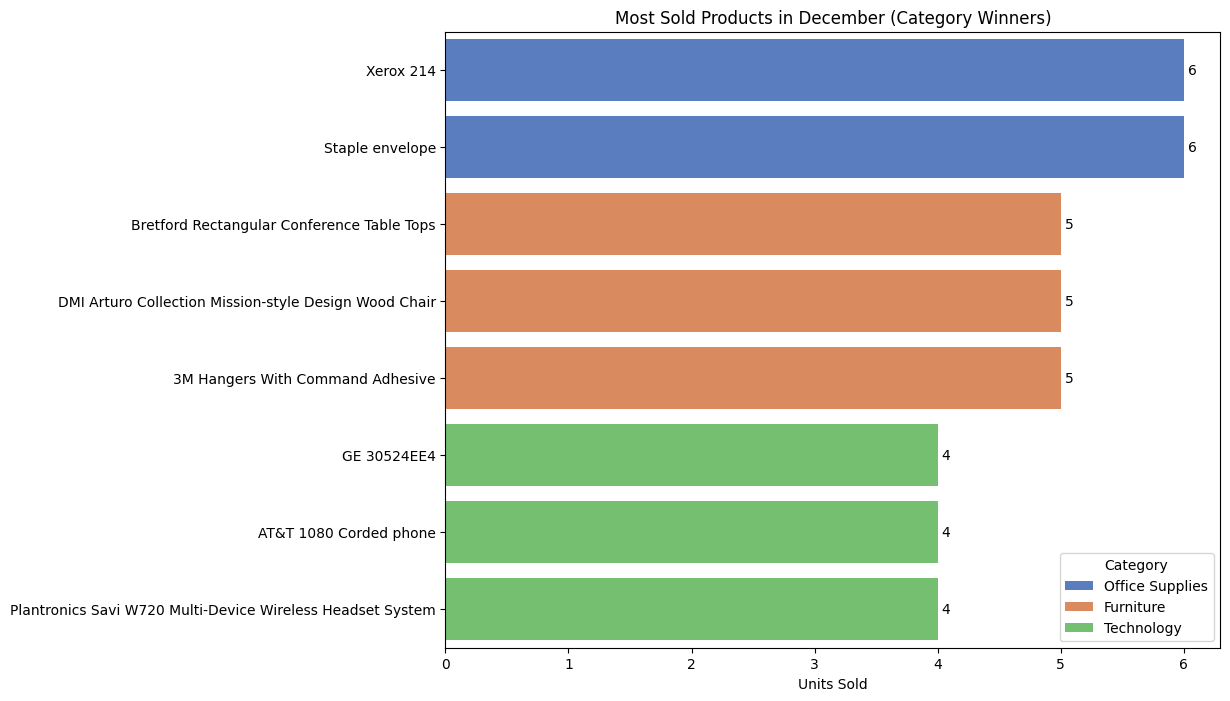

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convert Spark DataFrame to Pandas
# We limit to top 10 to keep the text readable
pdf7 = q7.limit(10).toPandas()

# 2. Create the Visual
plt.figure(figsize=(10, 8))

chart = sns.barplot(
    data=pdf7,
    y="Product Name",
    x="Units",
    hue="Category",
    dodge=False,
    palette="muted"
)

# 3. Add Labels
plt.title("Most Sold Products in December (Category Winners)")
plt.xlabel("Units Sold")
plt.ylabel("")
plt.legend(title="Category", loc="lower right")

# 4. Add the unit count at the end of each bar
for i in chart.containers:
    chart.bar_label(i, padding=3)

plt.show()

### 3.8 Identify Gold customers who purchase from only one category (specialists) versus those who purchase across all available categories (generalists). This is crucial for cross-selling strategies.

In [ ]:
from pyspark.sql.functions import max as _max, when, col, avg, count, round

# 1. Find the max
max_div = df5.agg(
    _max("Category_Diversity").alias("Max_Category_Diversity")
).collect()[0][0]

# 2. Assign label
df_comp = (
    df5.filter(col("Loyalty_Tier") == "Gold")
       .withColumn(
           "Buyer_Type",
           when(col("Category_Diversity") == 1, "Specialist")
           .when(col("Category_Diversity") == max_div, "Generalist")
           .otherwise("Mixed")
       )
)

# 3. Do the comparison
comparison = (
    df_comp.filter(col("Buyer_Type").isin("Specialist", "Generalist"))
           .groupBy("Buyer_Type")
           .agg(
               count("Buyer_Type").alias("Num_Customers"),
               round(avg("Lifetime_Value"), 2).alias("Avg_Lifetime_Value"),
               round(avg("Avg_Ticket_Size"), 2).alias("Avg_Ticket_Size")
           )
)

print("--- Q8: Comparison between Specialist vs Generalist ---")
comparison.show()

--- Q8: Comparison between Specialist vs Generalist ---
+----------+-------------+------------------+---------------+
|Buyer_Type|Num_Customers|Avg_Lifetime_Value|Avg_Ticket_Size|
+----------+-------------+------------------+---------------+
|Specialist|           18|           5394.18|        3566.88|
|Generalist|          358|            1458.7|         296.26|
+----------+-------------+------------------+---------------+



/tmp/ipython-input-506915948.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


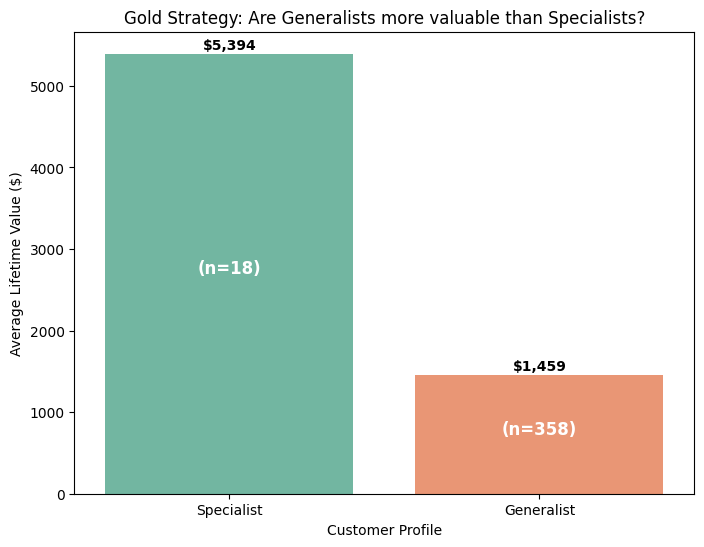

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convert Spark DataFrame to Pandas
pdf8 = comparison.toPandas()

# 2. Create the Visual
plt.figure(figsize=(8, 6))

# Plot Average Lifetime Value
ax = sns.barplot(
    data=pdf8,
    x="Buyer_Type",
    y="Avg_Lifetime_Value",
    palette="Set2"  # Distinct colors for contrast
)

# 3. Add Labels and Titles
plt.title("Gold Strategy: Are Generalists more valuable than Specialists?")
plt.ylabel("Average Lifetime Value ($)")
plt.xlabel("Customer Profile")

# 4. Add data labels (Dollar Amount + Count)
# This loop adds the value on top of the bar, and the customer count inside the bar
for i, row in enumerate(pdf8.itertuples()):
    # Label the Value on top
    ax.text(i, row.Avg_Lifetime_Value + 50, f"${row.Avg_Lifetime_Value:,.0f}",
            color='black', ha="center", fontweight='bold')

    # Label the Count (n=...) inside the bar
    ax.text(i, row.Avg_Lifetime_Value / 2, f"(n={row.Num_Customers})",
            color='white', ha="center", fontsize=12, fontweight='bold')

plt.show()

### 3.9 City Wealth Index. Instead of just one person, we analyze which cities have the highest concentration of "Gold Tier" customers.

In [ ]:
from pyspark.sql.functions import count, col, round, desc

# Insight: Cities ranked by their number of Gold Tier customers.

q9 = df5.filter(col("Loyalty_Tier") == "Gold") \
    .groupBy("City") \
    .agg(
        count("Customer ID").alias("Gold_Member_Count"),
        round(avg("Lifetime_Value"), 2).alias("Avg_Gold_Spend")
    ) \
    .orderBy(desc("Gold_Member_Count")) \
    .limit(5)

print("--- Q9: VIP Density per City (Where do Gold Members live?) ---")
q9.show()

--- Q9: VIP Density per City (Where do Gold Members live?) ---
+-------------+-----------------+--------------+
|         City|Gold_Member_Count|Avg_Gold_Spend|
+-------------+-----------------+--------------+
|New York City|               53|       2693.09|
|  Los Angeles|               45|       1882.27|
| Philadelphia|               32|       1552.85|
|      Seattle|               28|       2068.51|
|      Houston|               19|       1290.55|
+-------------+-----------------+--------------+



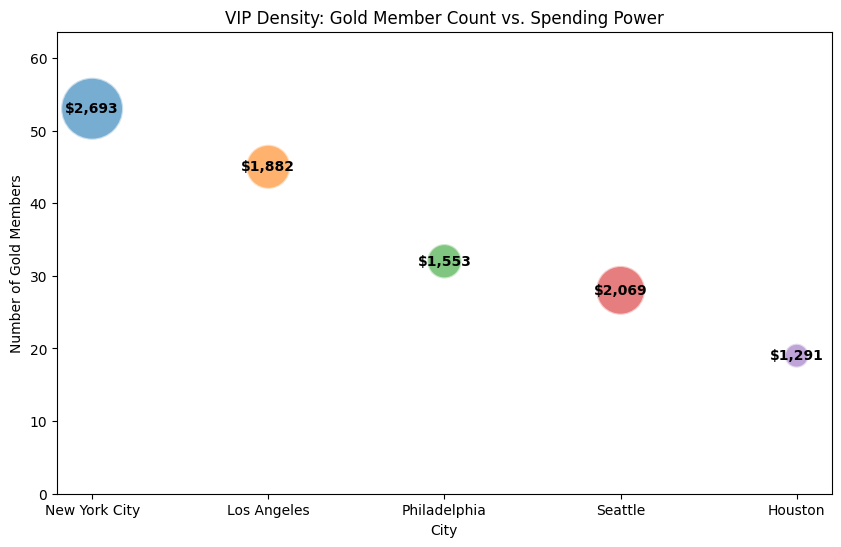

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convert Spark DataFrame to Pandas
pdf9 = q9.toPandas()

# 2. Create the Visual
plt.figure(figsize=(10, 6))

# Create the Bubble Chart
# size="Avg_Gold_Spend" makes wealthier cities have larger circles
sns.scatterplot(
    data=pdf9,
    x="City",
    y="Gold_Member_Count",
    size="Avg_Gold_Spend",
    sizes=(300, 2000),  # Min and Max size of bubbles
    hue="City",         # Color by city
    alpha=0.6,          # Transparency to see overlaps
    legend=False        # Hide default legend (we add labels instead)
)

# 3. Add Labels and Titles
plt.title("VIP Density: Gold Member Count vs. Spending Power")
plt.xlabel("City")
plt.ylabel("Number of Gold Members")

# Set Y-axis to start at 0 for accurate scale
plt.ylim(0, pdf9["Gold_Member_Count"].max() * 1.2)

# 4. Annotate bubbles with the Dollar Amount
# This helps the viewer read the "Size" value precisely
for i, row in enumerate(pdf9.itertuples()):
    plt.text(
        x=row.City,
        y=row.Gold_Member_Count,
        s=f"${row.Avg_Gold_Spend:,.0f}",
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=10,
        weight='bold',
        color='black'
    )

plt.show()

### 3.10 Which category brings in the most money?

In [ ]:
from pyspark.sql.functions import col, desc

# Simple Sort by Total Revenue
q10 = df6.orderBy(col("Total_Revenue").desc()).limit(1)

print("--- Q10: Highest Revenue Category ---")
q10.show()

--- Q10: Highest Revenue Category ---
+----------+-------------+---------------+
|  Category|Total_Revenue|Avg_Ticket_Size|
+----------+-------------+---------------+
|Technology|    827455.87|          456.4|
+----------+-------------+---------------+

